start this python session with:

ipython notebook --pylab inline current_measurement_requirements.ipynb

The 'inline' prints graphs inline.


In [21]:
from IPython.display import Image
import sympy
import math



###  Current Measurement Board Requirements 

* Must have a gain of 60
* Must have a GBW of 100kHz * 60 = 6MHz
* Must measure current range of (+-500uA, +-500mA)
* Must have a maximum differential voltage of >= 25mV
* Must have single ended analog line out
* Must have low current ground reference
* Must have two oscilloscope channels available: instrumentation_amp_out, Vref, and earth GND
* Must be possible to run on two CR2032 coin cells or on power from external power
* Must be able to short instrumentation amp terminals to check offset voltage
* Must have universal pad for different shunt resistors on end of I.A.
* Must have an onboard ADC.
* Must have SPI Interface of 25Mbits/s for the ADC.
* Must be able to sample the outputs of the differential op amp with an oscilloscope
* Must have >= 16bit resolution
* Must have disable jumper on SPI ADC
* Must be able to have ADC sample from instrumentation amp output or reference voltage
* Must have EN line on ADC
* Should have 0603 pads for filtering on differential end of I.A.
* Must have signal via + GND clip soldermask
* Should size shunt vias to accept 0.1" terminal block
* Should have two vias in each of three scope probes (this is to land the pointy scope probe)
* Should have 1.1mm diameter via for scope probe

It is convenient to define a maximum shunt voltage across the two inputs of the current sense amp.  Choose a shunt voltage of 50mV.  Given a 12 bit bipolar input range, this equates to about 50mV/2048 =~ 25uV minimum resolution  

In [13]:
shunt_voltage_max = .05 # 50mV max shunt voltage
sig_min = shunt_voltage_max/(2**11)
sig_min

2.44140625e-05

In [14]:
#  Temperature Offset

ad8210_offset_temp_drift = [(-40,35E-6),(-20,40E-6),(0,50E-6),(20,60E-6),(40,60E-6),(60,60E-6),(80,50E-6)]
max1144_offset_temp_drift = [(-40,-.0022),(-20,-.002),(0,-.0017),(20,-.0015),(40,-.0013),(60,-.0009),(80,-.0006)]
# offset error of the LTC231214 is given in LSB error.  Worst case, assume 4.096V reference.
lsb_error = 4.096/2**14
ltc231214_offset_temp_drift = [(-40,-.00018),(-20,-.00012),(0,-.0001),(20,-7.5E-5),(40,-5E-5),(60,-2.5E-5),(80,0)]
ad8210_gain = 20
nterms = len(ad8210_offset_temp_drift)
temp_drift = [[None,None] for _ in xrange(nterms)]
temp_array = [[None] for _ in xrange(len(ad8210_offset_temp_drift))]
offset_array_ad8210 =  [[None] for _ in xrange(len(ad8210_offset_temp_drift))]
offset_array_max1144 = [[None] for __ in xrange(len(max1144_offset_temp_drift))]
offset_array_ltc231214 = [[None] for __ in xrange(len(ltc231214_offset_temp_drift))]
for  idx in (range(nterms)):
    temp_array[idx] = ad8210_offset_temp_drift[idx][0]
    offset_array_ad8210[idx] =  ad8210_offset_temp_drift[idx][1]
    offset_array_max1144[idx] = max1144_offset_temp_drift[idx][1]
    offset_array_ltc231214[idx] = ltc231214_offset_temp_drift[idx][1]
print temp_array
print offset_array_ad8210
print offset_array_max1144
print offset_array_ltc231214
for i in range(nterms):
    temp_drift[i] = (temp_array[i],offset_array_ad8210[i]*ad8210_gain)
print temp_drift


import matplotlib.pyplot as plt
plt.scatter(*zip(*temp_drift))
plt.title('Combined Temperature Drift of Op-amp')
plt.xlabel('Temperature in Celsius')
plt.ylabel('ADC voltage output drift as function of temperature')
plt.show()


[-40, -20, 0, 20, 40, 60, 80]
[3.5e-05, 4e-05, 5e-05, 6e-05, 6e-05, 6e-05, 5e-05]
[-0.0022, -0.002, -0.0017, -0.0015, -0.0013, -0.0009, -0.0006]
[-0.00018, -0.00012, -0.0001, -7.5e-05, -5e-05, -2.5e-05, 0]
[(-40, 0.0006999999999999999), (-20, 0.0008), (0, 0.001), (20, 0.0012000000000000001), (40, 0.0012000000000000001), (60, 0.0012000000000000001), (80, 0.001)]


In [15]:
r = .470
i_drift_ma = [(t[0], t[1]*1000/r) for t in temp_drift]
print i_drift_ma
plt.scatter(*zip(*i_drift_ma))
plt.title('Current Measurement Error Over Temperature')
plt.xlabel('Temperature in Celsius')
plt.ylabel('Measured Current Error (mA) Over Temperature (R = .470 ohm)')
plt.show()

[(-40, 1.4893617021276593), (-20, 1.7021276595744683), (0, 2.127659574468085), (20, 2.5531914893617027), (40, 2.5531914893617027), (60, 2.5531914893617027), (80, 2.127659574468085)]


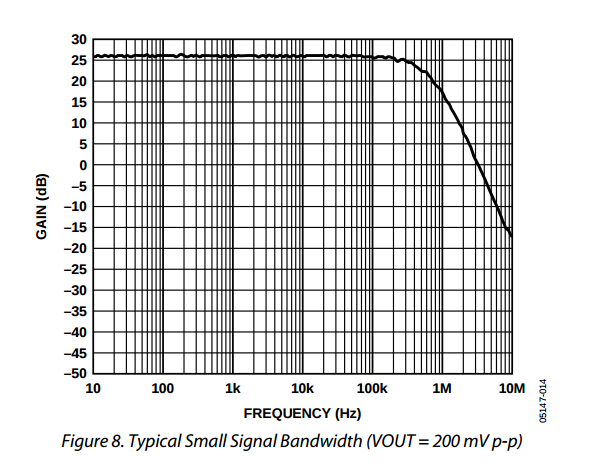

In [16]:
#  Bandwidth of the ADP8210
#  The Bandwidth is about 1MHz as illustrated in graph below

Image(filename='pictures/adp8210_smallsignal_gain.png')

In [17]:
#  Noise
#  0.1Hz to 10Hz, 2.3uV p-p
#  spectral noise 110 nV/sqrt(Hz)

# Consider the BW of the opamp (250kHz).
noise_hf = 110E-9/((250E3)**0.5)
print noise_hf
type(noise_hf)
print "noise_hf = %06.10f \n" %noise_hf

2.2e-10
noise_hf = 0.0000000002 



###  Offset Error AD8418

Maximum +-400uV drift over temperature.  This is kind of high considering that our minimum resolved signal (sig_min) is 25uV.  Also there is not a graph of the temperature drift.  The offset drift over temperature is not bad (less than 5uV over our region of interest).

![Offset Drift of the AD8418 is well below our 25uV minimum signal](./pictures/AD8418_offset_drift_over_temp.png)


The distribution of different AD8418 chips offset over temperature is centered at -35uV, with a narrow distribution that doesn't go beyond +-100uV.  

![](./pictures/AD8418_offset_voltage_distribution.png)

Given that the output is relatively stable over temperature, it makes sense to tune out our offset voltage in the circuit (or just ignore it and hope for the best which will only lose us a bit or two of resolution probably).




###  Bipolar AD8418

The AD8418 has a bipolar input range.  

###  Common Mode Input Range AD8418

The AD8418 has a -2V, +70V common mode input range.

###  Input Impedance AD8418

The datasheet gives an input bias current of 130uA.  Given that we are trying to detect currents down to 500uA, this is acceptable (though not great).  

### Output Impedance AD8418

The output impedance of the AD8418 (with a load resistance of 15kOhms) is 2 ohms.  The range is (.015V, Vs-.020V) which is nearly rail to rail.  The AD8418 will feed a high impedance active low pass filter, or perhaps an oscilloscope probe, or a relatively high impedance ADC front end, so the performance is probably adequate.

### Bandwidth AD8418

The AD8418 is not high bandwidth.  The performance starts to fall off above 300kHz.  The gain is still useful up to 1MHz.  This is adequate performance for measuring sub 100mA current consumption through multi-microfarad bypass networks.  For instance, a 50mV voltage drop caused by a 100mA current on a 10uF bypassed signal will take 5us (i.e. a 200kHz event).  So we'd really capture all of our current consumption events with a 2MHz sampling frequency (10 x the 200kHz resolves the waveform pretty well).  Unfortunately the gain on the current sense monitor is unit at about 1.5MHz.  So... good enough.

![](./pictures/AD8418_small_signal_bw.png)



In [18]:
0.05*1E-6/0.1


5e-07

###  Power Supply AD8418

The operating voltage of the AD8418 is (2.7V, 5.5V).  

The absolute max values for the power pins are 6V which is kind of weany, but good enough.

##  Selection of low pass op amp

Possible candidates:

AD8628     Analog Devices, Chopper stabilized, auto zero.  very low offset voltages.  Very low noise.  Power: (2.7V, 5V).  Rail to rail.  

LTC6255     Linear Technologies, Comes in 1,2,4 pack, low offset voltages ( 

.... wait a second, we don't need to worry about offset voltage or noise particularly, because with a gain of 20 from the front end current monitor, and a shunt voltage of between 20mV and 50mV, and a reference voltage on the ADC of 3.0V/2, then we only need an additional gain of 1.5 or 4. 

Here's a good one:

ADA4805   Analog Devices, rail to rail, low voltage (4.5V, 10V), low offset voltage (125uV max), Low noise (8Hz 1/f, 6nV/sqrt(Hz)).  The input common mode voltage range is:  (VS − 0.1 V to +VS − 1 V).    GBW = 100MHz+.  This device is a little bit expensive at USD2.53 q25 for the SOT23 single opamp package.  Also available in SC70-6 for USD3.17.  This is a high performance low power device that is the chip to beat.  

FAN4852    Fairchild/OnSemi, not quite rail to rail (output swing to within 10mV of either rail), low voltage (2.5V, 5V),  input common mode voltage range is: (-0.2V, 2.1V), low offset voltage (1.2mV worst case over temp), GBW = 9MHz, input noise 11nV/sqrt(Hz), USD.81 q25.  Available in 8MSOP.  The noise specifications for this part are mostly missing.  This is probably a good enough op amp.





###  opamp requirements in relation to the LT2312

The LT2312 datasheet lists two requirements for the input amplifier to the ADC (pg 12 of datasheet):

Maximum Output Impedance:  The amplifier must have an output impedance < 50 ohms at the operational bandwidth.
  The FAN4852 has an output impedance of 6 ohms at 6MHz.  

Minimum Bandwidth:  The closed loop bandwidth must be > 50MHz to ensure adequate settling time for 12 bit signals to allow full sampling throughput.  
  The FAN4852 has a 9MHz bandwidth.  


In [19]:
#  Calculation of ADC bandwidth

Cadc = -2E-6/(math.log(.99975)*50)
print Cadc

NameError: name 'math' is not defined

In [ ]:
#  Tim's calculation of the bandwidth requirement
#  The Tacq acquisition time of the ADC is 600ns, and the conversion time is 1400ns.  
#  Therefore the signal has to fall to 12 bits resolution within 600ns
#  Consider a falling signal
#  tadc = 600E-9
#  1./2**12 = math.exp(-tadc/tau)  
#  math.exp(-n) = 1./(2**12)        #  The signal falls from unity to 1/4096 in n time constants
#  n = 8.3
#  frequency = 1./600ns  = 1.66 MHz
#  frequency * n = 13.78MHz
#  This suggests that a 14MHz opamp driving the input of the ADC would be adequate to get the full 500ksps sampling
#  The bandwidth of the FAN4852 is 9MHz (with a 5V supply) which will probably be adequate given that we really care about 
#  a 100ksps.  The LT2312-12 recommends some >100MHz opamps such as the LT6200, but these cost USD 3, and are single packages
#  while the FAN4852 is only USD .35 for a dual package.  Therefore, proceed with the FAN4852 as it is probably barely good enough
#  not to notice any bandwidth limitations.


##  Choosing the Filter Topology and Type

Use a multiple feedback low pass filter.  Use two stages (the FAN4582 opamp is a dual package which makes this convenient).  Use a Bessel type filter so that the phase delay is constant.  
![](./pictures/multiple_fb_lp.png)

Use the reference documentation in: 

http://www.analog.com/media/en/training-seminars/design-handbooks/Basic-Linear-Design/Chapter8.pdf?doc=ADA4661-2.pdf

![](./pictures/bessel_chart.png)



In [22]:
# script to generate passive values for low pass filter
# Bessel Filter Values for 2nd order filter, page 8.48 from reference document:
Fc = 500000   #  Cutoff frequency in Hz
a1 = 1.916    #  alpha value for first stage of 4th order low pass bessel filter
a2 = 1.2414   #  alpha value for second stage of 4th order low pass bessel filter
F1 = 1.4192   #  Frequency cutoff normalization value for first stage of low pass bessel filter
F2 = 1.5912   #  Frequency cutoff normalization value for second stage of low pass bessel filter
"""
The shunt voltage is 20mV max,
The reference voltage is 2.048V.
The gain of the AD8418 is 20.
20mV * 20 V/V = 400mV
The reference voltage of the LTC2312 is 4.096V which split in half is 2.048V.
Therefore need gain of 2.048/400mV = 5.12
In two stages:  5.12**.5 = 2.26 , so round to 2.2

"""

H1 = 2.2        #  first stage gain. 
H2 = 2.2        #  second stage gain
C5 = 220E-12     #  Choose C5 value
Fc1 = Fc * F1    #  Cutoff frequency in Hz
k1 = 2*math.pi*Fc1*C5
C2 = 4*C5*(H1+1)/a1**2
R1 = a1/(2*H1*k1)
R3 = a1/(2*k1*(H1+1))
R4 = a1/(2*k1)

#  For the second stage of the filter, add a zero to the names of the components, i.e. R4 -> R40

C50 = C5    #  C50 set from earlier C5 choice
Fc2 = Fc * F2    #  Cutoff frequency in Hz
k2 = 2*math.pi*Fc2*C50
C20 = 4*C50*(H2+1)/a2**2
R10 = a2/(2*H2*k2)
R30 = a2/(2*k2*(H2+1))
R40 = a2/(2*k2)

print "C5 =  " '{0:.12f}'.format(C5)
print "C2 =  " '{0:.12f}'.format(C2)
print "R1 =  " '{0:.12f}'.format(R1)
print "R3 =  " '{0:.12f}'.format(R3)
print "R4 =  " '{0:.12f}'.format(R4)
print "C50 =  " '{0:.12f}'.format(C50)
print "C20 =  " '{0:.12f}'.format(C20)
print "R10 =  " '{0:.12f}'.format(R10)
print "R30 =  " '{0:.12f}'.format(R30)
print "R40 =  " '{0:.12f}'.format(R40)



C5 =  0.000000000220
C2 =  0.000000000767
R1 =  443.942447735762
R3 =  305.210432818337
R4 =  976.673385018677
C50 =  0.000000000220
C20 =  0.000000001827
R10 =  256.543928531353
R30 =  176.373950865305
R40 =  564.396642768976


In [ ]:
math.log(2.714)


##  Choosing the cutoff frequency of the filter.

The stm32F4 has a 12bit ADCs that can sample up to 32MHz.  (See page 6.3.21 of DM00071990_STM32F42x_Datasheet_Rev_5_Feb_2015.pdf).  The AD8418 has a bandwidth of a little over 1MHz.  
The LTC2312 ADC has a sample rate of 500ksps.  

Given the requirement that the device have a gain band width of 6MHz, with 60 gain at 100kHz.  It makes sense to do a cutoff at 500kHz.  

##  Choosing the gain of the bessel filter

The maximum voltage across the shunt resistor is 50mV.  The gain from the AD8418 is 20V/V (though figure 6 from the datasheet which shows the small signal gain appears as 27dB with a 200kHz cutoff).  The input range of the ADC either on board (LTC2312) or offboard (STM32) will be 3.3V (round down to 3V). This means that we would only need a gain of 3 from the Bessel active filter.  All things the same,  Let's scale the voltage across the shunt resistor to 20mV which will mean we need a gain of 7.5 from the bessel filter. 